In [1]:
import pandas as pd
import numpy as np
import scipy
print(scipy.__version__)
from datetime import datetime

import autosklearn.classification

import sklearn.model_selection
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import plot_partial_dependence, permutation_importance

import matplotlib.pyplot as plt

1.7.3


In [2]:
#Movies: movieId, title, genres
#Rating: userId, movieId, rating, timestamp 
#Tag: userId, movieId, tag, timestamp

# genome_scores = pd.read_csv('data/genome_scores.csv')
# genome_tags = pd.read_csv('data/genome_tags.csv')
# movies = pd.read_csv('data/movie.csv')
rating = pd.read_csv('data/rating.csv')
tag = pd.read_csv('data/tag.csv')
rating.head()

rating = rating.drop(['timestamp'], axis=1)
# movies = movies.drop(['title'], axis=1)

In [3]:
def getSample(rating, tag, start, end):
    #Get Rating subframe
    rating_sub = rating[rating['userId'].between(start,end)]
    # Merge Tag sub frame with Rating
    rating_sub = rating_sub.merge(tag[tag['userId'].between(start,end)], how='outer', on=['userId','movieId'])
    rating_sub = rating_sub.dropna()
    # rating_sub.head()
    return rating_sub

In [4]:
def getPreprocess(rating_sub):
    # Turn datetime into 4 columns and add cyclic 
    dfr = rating_sub.copy()

    # Separate year-month-day-time
    dfr['year'] = pd.DatetimeIndex(dfr['timestamp']).year
    dfr['month'] = pd.DatetimeIndex(dfr['timestamp']).month
    dfr['day'] = pd.DatetimeIndex(dfr['timestamp']).day
    # Turn time into total minutes 
    dfr['minutes'] = pd.DatetimeIndex(dfr['timestamp']).hour * 60 + pd.DatetimeIndex(dfr['timestamp']).minute + pd.DatetimeIndex(dfr['timestamp']).second/60
    dfr = dfr.drop(['timestamp'], axis=1)

    # Add cyclical (added .05 to the R^2)
    dfr['Month_sin'] = np.sin(2*np.pi*dfr.month/12) #Month
    dfr['Month_cos'] = np.cos(2*np.pi*dfr.month/12)
    dfr.drop('month', axis=1, inplace=True)

    dfr['Day_sin'] = np.sin(2*np.pi*dfr.day/30) #Day (30 should be close enough)
    dfr['Day_cos'] = np.cos(2*np.pi*dfr.day/30)
    dfr.drop('day', axis=1, inplace=True)

    dfr['sin_minutes'] = np.sin(2*np.pi*dfr.minutes/1440) #Minute (1440 minutes in a day)
    dfr['cos_minutes'] = np.cos(2*np.pi*dfr.minutes/1440)
    dfr.drop('minutes', axis=1, inplace=True)

    ## add tag word count as feature:
    tag_f = dfr.iloc[:,3].to_string(index=False).split('\n')
    for t in range(len(tag_f)):
        tag_f[t] = tag_f[t].strip()

    tag_len = [0 for _ in range(len(tag_f))]
    tag_punc = [0 for _ in range(len(tag_f))]
    for i, tg in enumerate(tag_f):
        tag_len[i] = len(tg.split())
        tag_punc[i] = (len(tg.split('?')) + len(tg.split('!')) - 2)

    dfr['tag_len'] = tag_len
    dfr['tag_punc'] = tag_punc
    dfr = dfr.drop(['tag'], axis=1)  # drop tag column
    dfr.head(5)
    
    # print('Dtypes:',dfr.dtypes)
    print(dfr.shape)
    dfr.tail()
    
    return dfr

In [7]:
# Roc
def rocPlot(fpr, tpr):
    #create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [11]:
def model(dfr):
    # Get train and test splits
    X_train, X_test, y_train, y_test=train_test_split(dfr.iloc[:,1:], dfr.iloc[:,0], 
                                                      test_size=0.3, 
                                                      random_state=10)
    y_test = list(y_test)
    y_train = list(y_train)
    X_train.head()

    # Build and fit AutoML classification model
    auto = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=(60*5), per_run_time_limit=90)
    auto.fit(X_train, y_train)

    leaderboard = auto.leaderboard()
    # print(auto.leaderboard())
    
    
    y_hat_auto = auto.predict(X_train)
    trainR2 = sklearn.metrics.r2_score(y_train, y_hat_auto)
    print("Training R2 score:", trainR2)
    y_hat_test = auto.predict(X_test)
    testR2 = sklearn.metrics.r2_score(y_test, y_hat_test)
    print("Test R2 score:", testR2, '\n')
    
    #ROC Curve
    # y_pred_proba = auto.predict_proba(X_test)[::,1]
    # fpr, tpr, _ = sklearn.metrics.roc_curve(y_test,  y_pred_proba)
    # rocPlot(fpr, tpr)  
    
    # print('F1 Score: ' ,f1_score(y_true, y_pred, average='weighted'))
    
    return auto, leaderboard, trainR2, testR2

In [12]:
# Inputs to full run
interval = 6000
sampleI = 1
uniqueUserIds = 138493 
fullI = uniqueUserIds//interval # number of runs to get through entire dataset (not using remainder)

# Store output info for graphing
lastModel = None
trainRes = []
testRes = []
starts = []
models = []
avgReviewsPerUser = [] # length/interval per run

# Copy to avoid Dataframe weirdness
ratingCopy = rating.copy()
tagCopy = tag.copy()

now = datetime.now()
curtime = now.strftime("%H:%M:%S")
fname = ('Results' + '_' + curtime)
with open('%s.txt' %fname, 'w') as f: # name file after time of running
    f.write('Results:\n')
    
    for i in range(sampleI): # 138k userIds
        start = i * interval
        end = (i+1) * interval  
        f.write('\n\n')
        print('_Iteration:_ ', i)
        
        # Do the things
        data = getSample(ratingCopy, tagCopy, start, end)
        dfr = getPreprocess(data)
        model, lead, trainR2, testR2 = model(dfr)
        
        f.write('For samples:')
        f.write(str(start))
        f.write(' to ')
        f.write(str(end))
        f.write('\nLeaderboard:')
        f.write(str(lead))
        f.write('\nTraining R2 score: ')
        f.write(str(trainR2))
        f.write('\nTest R2 score: ')
        f.write(str(testR2))
        
        # Metadata
        trainRes.append(trainR2)
        testRes.append(testR2)
        starts.append(start)
        models += list(lead.type)
        lastModel = model 
        avgReviewsPerUser.append((len(dfr.index))/interval)
    
    f.close()

_Iteration:_  0
(20731, 12)
Training R2 score: 0.966318968957321
Test R2 score: 0.8947741203745623 



ValueError: multiclass format is not supported

Metadata:
- Interval:  6000
- Iterations: 23
- Mean Reviews per User: 2.8200289855072462
- Mean Training R Squared:  0.9664022372782913
- Mean Testing R Squared:  0.8744467979807686


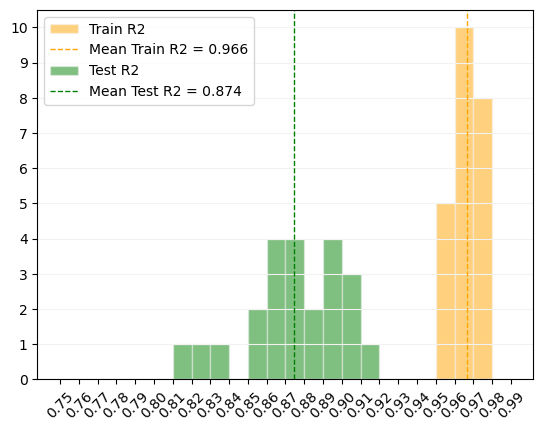

In [12]:
# Analysis and Visualization
trMean = np.mean(trainRes)
trmeanstr = 'Mean Train R2 = ' + str(trMean.round(3)) 
teMean = np.mean(testRes)
temeanstr = 'Mean Test R2 = ' + str(teMean.round(3))
print('Metadata:')
print('- Interval: ', interval)
print('- Iterations: 23')
print('- Mean Reviews per User:' , np.mean(avgReviewsPerUser)) # sampleI or fullI
print('- Mean Training R Squared: ', np.mean(trainRes))
print('- Mean Testing R Squared: ', np.mean(testRes))

# Plot R^2 scores
# bins = np.linspace(.8, 1, 15)
bins = np.arange(.75, 1, .01)
plt.xticks(bins, rotation=45)
plt.yticks((np.arange(0,20,1)))

plt.hist(trainRes, bins, alpha=0.5, color='orange', label='Train R2', edgecolor='.95')
plt.axvline(np.mean(trainRes), color='orange', label=trmeanstr, linestyle='dashed', linewidth=1)

plt.hist(testRes, bins, alpha=0.5, color='green', label='Test R2', edgecolor='.95')
plt.axvline(np.mean(testRes), color='green', label=temeanstr, linestyle='dashed', linewidth=1)

plt.legend(loc='upper left')
plt.grid(axis='y', color='0.95')
plt.show()

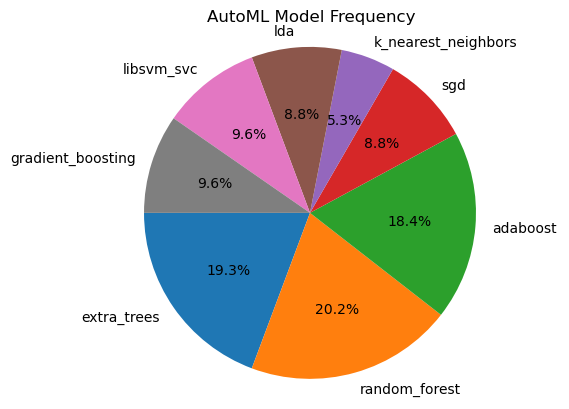

In [8]:
# Plot frequency of each model

# print('models',models)
uniqModels = []
modelFreqs = []
for i in range(len(models)):
    if(models[i] not in uniqModels):
       uniqModels.append(models[i])
       modelFreqs.append(1)
    else:
       indx = uniqModels.index(models[i])
       modelFreqs[indx] += 1

fig1, ax1 = plt.subplots()
ax1.pie(modelFreqs, labels=uniqModels, autopct='%1.1f%%', startangle=180)
plt.title('AutoML Model Frequency')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.grid(True)
plt.show()

In [ ]:
#define metrics
y_pred_proba = auto.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# gendict = {}
# for gen in movies['genres']:
#     split = gen.split('|')
#     for s in split:
#         if s in gendict.keys():
#             gendict[s] += 1
#         else:
#             gendict[s] = 1
# print(len(gendict))
# print(gendict.keys())
# genres = list(gendict.keys())
# rating_sub = rating[rating['userId'] <= 10000]
# rating_sub = rating[rating['userId'].between(10001,20000)]
# genrray = np.zeros((rating_sub.shape[0], len(genres)))
# r = 0
# for mi in rating_sub['movieId']:
#     ind = movies.index[movies['movieId']==int(mi)][0]
#     gens = movies.iloc[ind,1].split('|')
    # for g in gens:
    #     genrray[r,genres.index(g)] = 1
    # r += 1
# colen = 3
# for nc in genrray.T:
#     rating_sub.insert(colen, genres[colen-3], nc)
#     colen += 1
# rating_sub.append(pd.DataFrame(genrray, columns = genres))
# rating_sub.head(5)
# rating_sub = rating_sub.merge(tag[tag['userId'].between(10001,20000)], how='outer', on=['userId','movieId'])

# rating_sub = rating_sub.dropna()
# rating_sub.head()